In [81]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import itertools
from tqdm import tqdm

# SARIMA model
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Seq2seq
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Prédire février 2005 et mars 2005. Entraîner de février 2003 à janvien 2005
df = pd.concat([pd.read_parquet('data/tec_2003.parquet.gzip'), pd.read_parquet('data/tec_2004.parquet.gzip'), pd.read_parquet('data/tec_2005.parquet.gzip')])
df

,time,gdlat,glon,tec,datetime,year,month,day,hour,minute,second
3570,1.041379e+09,59.0,136.0,10.7,2003-01-01 00:02:30,2003,1,1,0,2,30
3571,1.041379e+09,59.0,137.0,10.6,2003-01-01 00:02:30,2003,1,1,0,2,30
3613,1.041379e+09,60.0,143.0,10.0,2003-01-01 00:02:30,2003,1,1,0,2,30
3679,1.041379e+09,62.0,134.0,7.0,2003-01-01 00:02:30,2003,1,1,0,2,30
7679,1.041380e+09,59.0,136.0,10.7,2003-01-01 00:07:30,2003,1,1,0,7,30
...,...,...,...,...,...,...,...,...,...,...,...
21918479,1.136073e+09,59.0,140.0,7.5,2005-12-31 23:52:30,2005,12,31,23,52,30
21918600,1.136073e+09,62.0,141.0,5.3,2005-12-31 23:52:30,2005,12,31,23,52,30
21923482,1.136073e+09,58.0,139.0,8.2,2005-12-31 23:57:30,2005,12,31,23,57,30
21923483,1.136073e+09,58.0,140.0,7.9,2005-12-31 23:57:30,2005,12,31,23,57,30


In [4]:
df_siberia = df [(df['gdlat'] >= 56.0) & (df['gdlat'] <= 58.0) & (df['glon'] >= 136.0) & (df['glon'] <= 140.0)][['datetime', 'gdlat', 'glon', 'tec']].copy()
df_siberia

,datetime,gdlat,glon,tec
66026,2003-01-01 01:17:30,57.0,136.0,14.0
70328,2003-01-01 01:22:30,57.0,137.0,13.6
74634,2003-01-01 01:27:30,57.0,137.0,13.5
74635,2003-01-01 01:27:30,57.0,138.0,13.5
74673,2003-01-01 01:27:30,58.0,138.0,13.5
...,...,...,...,...
21795798,2005-12-31 21:52:30,56.0,140.0,5.1
21795846,2005-12-31 21:52:30,57.0,140.0,5.0
21918433,2005-12-31 23:52:30,58.0,140.0,7.8
21923482,2005-12-31 23:57:30,58.0,139.0,8.2


### Manipulation de données

In [7]:
def equilibrate_regions(df):
    duplicate = np.max(pd.crosstab(df['gdlat'], df['glon'])) // pd.crosstab(df['gdlat'], df['glon']) - 1
    sample = np.max(pd.crosstab(df['gdlat'], df['glon'])) % pd.crosstab(df['gdlat'], df['glon'])
    for gdlat in duplicate.index:
        for glon in duplicate.columns:
            # Duplicate
            df_lat_lon = df[ (df['gdlat'] == gdlat) & (df['glon'] == glon) ].reset_index(drop=True)
            add = [df_lat_lon]*duplicate.loc[gdlat, glon]
            # Sample
            sampled_indices = np.random.choice(df_lat_lon.index, size=sample.loc[gdlat, glon], replace=False)
            add.append(df_lat_lon.loc[sampled_indices, :])
            # Add new rows
            if add:
                add = pd.concat(add)
                df = pd.concat([df, add]).reset_index(drop=True)
    return df.sort_values(by='datetime').reset_index(drop=True)

In [9]:
def average_by_2hourly_bin(df, datetime_col, measure_col):
    """
    Average values within 2-hour bins.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing datetime and measure columns
    datetime_col : str
        Name of the datetime column
    measure_col : str
        Name of the measure column
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with 2-hourly timestamps and averaged values
    """
    df = df.copy()
    
    # Create regular 2-hourly time index
    start_time = df[datetime_col].min().floor('2h')
    end_time = df[datetime_col].max().ceil('2h')
    two_hourly_index = pd.date_range(start=start_time, end=end_time, freq='2h')
    
    # Bin data into 2-hour intervals and calculate mean
    df[datetime_col] = pd.to_datetime(df[datetime_col]).dt.floor('2h')
    result = df.groupby(datetime_col)[measure_col].mean().reindex(two_hourly_index)
    
    # Convert to dataframe
    result_df = result.reset_index()
    result_df.columns = [datetime_col, measure_col]
    
    return result_df

In [12]:
def create_trajectory_matrix(time_series, window):
    """
    Create trajectory matrix from time series using sliding window.
    
    Args:
        time_series (array-like): Input time series
        window (int): Window size
        
    Returns:
        np.ndarray: Trajectory matrix
    """
    n = len(time_series)
    k = n - window + 1
    matrix = np.zeros((k, window))
    
    for i in range(k):
        matrix[i, :] = time_series[i:i + window]
        
    return matrix

In [71]:
def low_rank_interpolate(X, W, K, max_iter=100, tol=1e-6):
    """
    Interpolate missing values in trajectory matrix using low rank approximation.
    
    Args:
        X (np.ndarray): Trajectory matrix with missing values
        W (np.ndarray): Mask matrix (1 for observed, 0 for missing)
        K (int): Expected rank
        max_iter (int): Maximum iterations
        tol (float): Convergence tolerance
        
    Returns:
        np.ndarray: Interpolated trajectory matrix
    """
    X_hat = np.zeros_like(X)
    X_hat[W == 0] = np.mean(X[W == 1])  # Initialize missing values with mean

    prev_norm = np.inf
    prev_criterion = np.inf
    for _ in tqdm(range(max_iter)):
        # Combine observed values from X and interpolated values from X_hat
        Y = X + X_hat * (1 - W)
        
        # SVD computation
        U, s, Vt = svd(Y, full_matrices=False)
        
        # Low rank approximation
        X_hat = sum(s[k] * np.outer(U[:, k], Vt[k, :]) for k in range(min(K, len(s))))
        
        # Check convergence
        current_norm = np.linalg.norm(X_hat * (1 - W))
        current_criterion = abs(current_norm - prev_norm)
        if current_criterion > prev_criterion: # diverging
            break
        if current_criterion < tol:
            break
        prev_norm = current_norm
        prev_criterion = current_criterion
        
    return X_hat


In [72]:
def recover_time_series(trajectory_matrix):
    """
    Recover original time series from trajectory matrix using diagonal averaging.
    
    Args:
        trajectory_matrix (np.ndarray): Matrix of shape (n - window_size + 1, window_size)
    
    Returns:
        np.ndarray: Recovered time series of length n
    """
    L = trajectory_matrix.shape[1]  # window_size
    K = trajectory_matrix.shape[0]  # n - window_size + 1
    n = L + K - 1  # original series length
    
    recovered = np.zeros(n)
    counts = np.zeros(n)
    
    # Fill the recovered series using diagonal averaging
    for i in range(K):
        for j in range(L):
            recovered[i + j] += trajectory_matrix[i, j]
            counts[i + j] += 1
            
    # Normalize by the number of elements in each diagonal
    recovered = recovered / counts
    
    return recovered

In [73]:
def get_train_and_test(train_start, test_start, test_end, k_singular_values=24, trajectory_window=120):
    # train
    print('Preprocessing train set...')
    df_siberia_train = df_siberia [(df_siberia['datetime'] >= train_start) & (df_siberia['datetime'] < test_start)]
    df_siberia_train_equilibrate = equilibrate_regions(df_siberia_train)
    df_siberia_train_equilibrate_2hourly = average_by_2hourly_bin(df_siberia_train_equilibrate, 'datetime', 'tec').iloc[:-1]
    df_siberia_train_equilibrate_2hourly = df_siberia_train_equilibrate_2hourly.set_index('datetime')
    X = create_trajectory_matrix(df_siberia_train_equilibrate_2hourly['tec'].to_numpy(), trajectory_window)
    W = (~np.isnan(X)).astype(int)
    X = np.nan_to_num(X)
    estimated_trajectory_matrix = low_rank_interpolate(X, W, k_singular_values) # keep first 24 singular values 
    train = pd.Series(recover_time_series(estimated_trajectory_matrix), index=df_siberia_train_equilibrate_2hourly.index)

    # test
    print('Preprocessing test set...')
    df_siberia_test = df_siberia [(df_siberia['datetime'] >= train_start) & (df_siberia['datetime'] < test_end)]
    df_siberia_test_equilibrate = equilibrate_regions(df_siberia_test)
    df_siberia_test_equilibrate_2hourly = average_by_2hourly_bin(df_siberia_test_equilibrate, 'datetime', 'tec').iloc[:-1]
    df_siberia_test_equilibrate_2hourly = df_siberia_test_equilibrate_2hourly.set_index('datetime')
    X = create_trajectory_matrix(df_siberia_test_equilibrate_2hourly['tec'].to_numpy(), trajectory_window)
    W = (~np.isnan(X)).astype(int)
    X = np.nan_to_num(X)
    estimated_trajectory_matrix = low_rank_interpolate(X, W, k_singular_values) # keep first 24 singular values 
    test = pd.Series(recover_time_series(estimated_trajectory_matrix), index=df_siberia_test_equilibrate_2hourly.index)
    
    return train, test.loc[test_start:test_end]

In [74]:
train, test = get_train_and_test('2003-02-25', '2005-02-25', '2005-03-06')

Preprocessing train set...


 45%|████▌     | 45/100 [03:53<04:45,  5.19s/it]


Preprocessing test set...


 45%|████▌     | 45/100 [03:32<04:20,  4.73s/it]


### SARIMA

In [75]:
# Fit model with best parameters, d=0 and D=1
model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(2, 1, 2, 12)).fit(maxiter=100)
print(r"\nModel summary:")
print(model.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16242D-01    |proj g|=  2.27561D+00

At iterate    5    f= -2.67244D-01    |proj g|=  1.05247D+00

At iterate   10    f= -4.01263D-01    |proj g|=  4.09145D-01

At iterate   15    f= -4.17096D-01    |proj g|=  1.03589D-01

At iterate   20    f= -4.22447D-01    |proj g|=  1.26257D-01

At iterate   25    f= -4.30138D-01    |proj g|=  2.11139D-01

At iterate   30    f= -4.35413D-01    |proj g|=  3.78169D-02

At iterate   35    f= -4.35956D-01    |proj g|=  5.26632D-03

At iterate   40    f= -4.36129D-01    |proj g|=  3.24082D-03

At iterate   45    f= -4.36133D-01    |proj g|=  3.48042D-04

At iterate   50    f= -4.36136D-01    |proj g|=  1.14982D-02

At iterate   55    f= -4.36139D-01    |proj g|=  1.94385D-03

At iterate   60    f= -4.36139D-01    |proj g|=  6.55380D-04

At iterate   65    f= -4.3

In [76]:
model.mle_retvals['converged']

True

In [77]:
predict = model.forecast(steps=108)
predict

2005-02-25 00:00:00    13.078542
2005-02-25 02:00:00    12.811454
2005-02-25 04:00:00    12.203700
2005-02-25 06:00:00    10.755404
2005-02-25 08:00:00     9.946085
                         ...    
2005-03-05 14:00:00     3.556629
2005-03-05 16:00:00     6.555421
2005-03-05 18:00:00     5.941313
2005-03-05 20:00:00     5.329550
2005-03-05 22:00:00     6.610938
Freq: 2h, Name: predicted_mean, Length: 108, dtype: float64

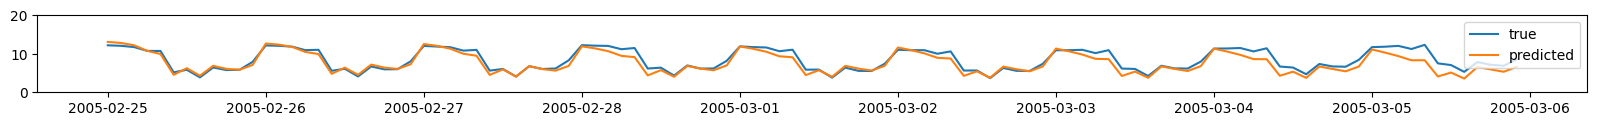

In [78]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(test, label='true')
plt.plot(predict, label='predicted')
plt.legend()

In [86]:
print(f'Correlation of the Seq2seq model: {pearsonr(test, predict).statistic}')
print(f'RMSE of the Seq2seq model: {np.sqrt(mean_squared_error(test, predict))}') # np.sqrt(np.mean((test - predict)**2))

Correlation of the Seq2seq model: 0.9353461335189627
RMSE of the Seq2seq model: 1.2021873735413415


### LSTM

In [ ]:
test2 = df_siberia [(df_siberia['datetime'] >= '2005-02-20') & (df_siberia['datetime'] < '2005-03-06')] 

In [13]:
sequence_length = 50
test2 = test2[len(test2) - len(test) - sequence_length:]

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)

sequence_length = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [38]:
num_lstm_layers = 2
dropout_rate = 0.2
batch_size = 48
epochs = 500
validation_split = 0.05
input_dim = 1
output_dim = 1

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(sequence_length, input_dim)))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(units=output_dim, activation='linear'))

model.compile(optimizer='Adam', loss='mae', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)

2024-12-23 10:08:51.006876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0839 - mae: 0.0839 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 2/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0485 - val_mae: 0.0485
Epoch 3/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0589 - mae: 0.0589 - val_loss: 0.0479 - val_mae: 0.0479
Epoch 4/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 5/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0531 - val_mae: 0.0531
Epoch 6/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0605 - mae: 0.0605 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 7/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0495 - val_mae: 0.0495
Epoch 8/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0560 - mae: 0.0560 - val_loss: 0.0494 - val_mae: 0.0494
Epoch 9/500
173/173 ━━━━━━━━━━━━━━━━━━━

In [62]:
model.save('lstm/lstm_model.keras')

In [35]:
lstm_model = load_model('lstm/lstm_model.keras')

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.fit_transform(test2)

sequence_length = 50
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])

X_test = np.array(X_test)
y_test = np.array(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1391 - mae: 0.1391
Loss on test data: 0.14032581448554993
MAE on test data: 0.14032581448554993


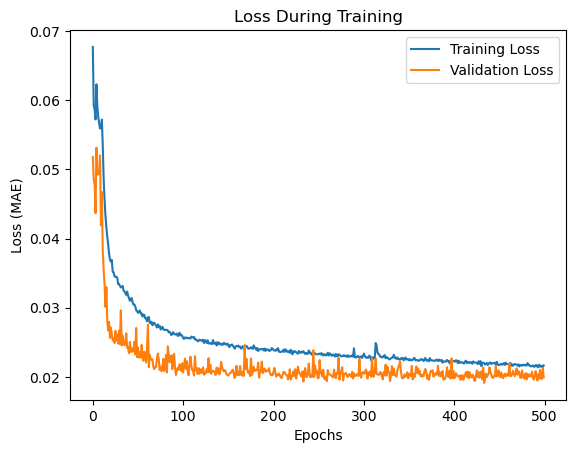

In [116]:
# Visualisation sur le dataset de test
loss, mae = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Loss on test data: {loss}")
print(f"MAE on test data: {mae}")

# Visualisation de l'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


RMSE of the LSTM model 6.7817073
Correlation of the LSTM model 0.77553884890125


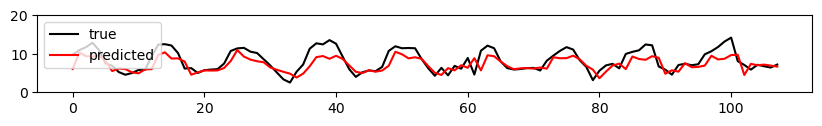

In [57]:
unscaled_lstm_prediction = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(unscaled_lstm_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(10, 1))
plt.ylim(0, 20)
plt.plot(unscaled_y_test, label='true', color='black')
plt.plot(lstm_predictions, label='predicted', color='red')
plt.legend()

lstm_rmse = np.sqrt(np.mean(unscaled_seq_prediction - lstm_predictions)**2)
print('RMSE of the LSTM model', lstm_rmse)

lstm_correlation = correlation(lstm_predictions, unscaled_y_test)
print('Correlation of the LSTM model', lstm_correlation)

### Seq2Seq

In [ ]:
learning_rate = 0.01
lambda_l2_reg = 0.003
hidden_dim = 64
num_lstm_layers = 1  
gradient_clipping = 2.5
num_input_signals = 1
num_output_signals = 1

model = Sequential()

model.add(LSTM(
    units=hidden_dim, 
    activation='relu', 
    input_shape=(X_train.shape[1], num_input_signals), 
    return_sequences=False, 
    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2_reg)
))

model.add(Dense(units=num_output_signals))

optimizer = Adam(learning_rate=learning_rate, clipvalue=gradient_clipping)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=1500,
    batch_size=48,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0094 - mae: 0.0697 - val_loss: 0.0079 - val_mae: 0.0747
Epoch 2/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0057 - mae: 0.0571 - val_loss: 0.0055 - val_mae: 0.0618
Epoch 3/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0050 - mae: 0.0539 - val_loss: 0.0036 - val_mae: 0.0435
Epoch 4/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0037 - mae: 0.0424 - val_loss: 0.0060 - val_mae: 0.0637
Epoch 5/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0027 - mae: 0.0358 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 6/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0025 - mae: 0.0354 - val_loss: 0.0017 - val_mae: 0.0292
Epoch 7/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0031 - val_mae: 0.0441
Epoch 8/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0021 - mae: 0.0328 - val_loss: 0.0020 - val_mae: 0.0326
Epoch 9/1500
146/146 ━━━━━━━━━━━

In [ ]:
model.save('seq2seq/seq2seq_model.keras')

In [27]:
seq2seq_model = load_model('seq2seq/seq2seq_model.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE of the Seq2seq model 7.5917516
Correlation of the Seq2seq model 0.859081610584248


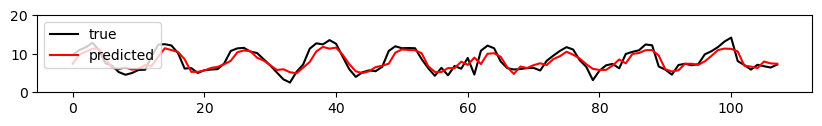

In [55]:
unscaled_seq_prediction = seq2seq_model.predict(X_test)
seq2seq_predictions = scaler.inverse_transform(unscaled_seq_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(10, 1))
plt.ylim(0, 20)
plt.plot(unscaled_y_test, label='true', color='black')
plt.plot(seq2seq_predictions, label='predicted', color='red')
plt.legend()

seq_rmse = np.sqrt(np.mean(unscaled_seq_prediction - seq2seq_predictions)**2)
print('RMSE of the Seq2seq model', seq_rmse)

seq_correlation = correlation(seq2seq_predictions, unscaled_y_test)
print('Correlation of the Seq2seq model', seq_correlation)